<a href="https://colab.research.google.com/github/kasiakry/ml2-big-dataset/blob/master/bank-telemarketing_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the Success of Bank Telemarketing
## Project by Piotr Borowski & Katarzyna Kryńska

## Introduction




## Attribute Description

Input variables:
* bank client data:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
* related with the last contact of the current campaign:
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
* other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
* social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: 'yes','no')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/kasiakry/ml2-big-dataset/master/bank-additional-full.csv', sep=';')

In [17]:
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Fortunately, the dataset does not contain any missing values.

In [23]:
df.isna().values.any()

False

### Exploratory data analysis

Firstly, we will check the number of clients that subscribed to a term deposit vs the number of clients that did not. We can see that the dataset is moderately imbalanced - number of clients that subscribed to a term deposit equals to 11.27% of the whole dataset. This means that accuracy might be not the best metric to measure performance of our classification models and also that it might be wise to use some techniques to work with imbalanced datasets, such as oversampling, undersampling or generating synthetic samples. 

Campaign overall success rate:  11.27%


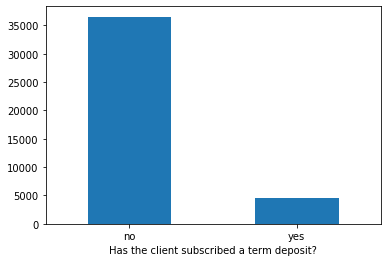

In [119]:
barplot = df['y'].value_counts().plot.bar(rot=0)
barplot.set_xlabel('Has the client subscribed a term deposit?');
print('Campaign overall success rate: ', '{:2.2%}'.format(df_count['yes'] / (df_count['no'] + df_count['yes'])))

Now we will look into distributions of numerical data in the dataset by plotting histograms. Firstly, we can see that in our dataset there is not many people in the age of 60+. Interestingly, we can divide our dataset in regard to Euribor rate into two groups - one with rate around 1% and the second one with rate from 4 to 5%. We can also notice that most of the dataset consists of clients who the company had not contacted before. 

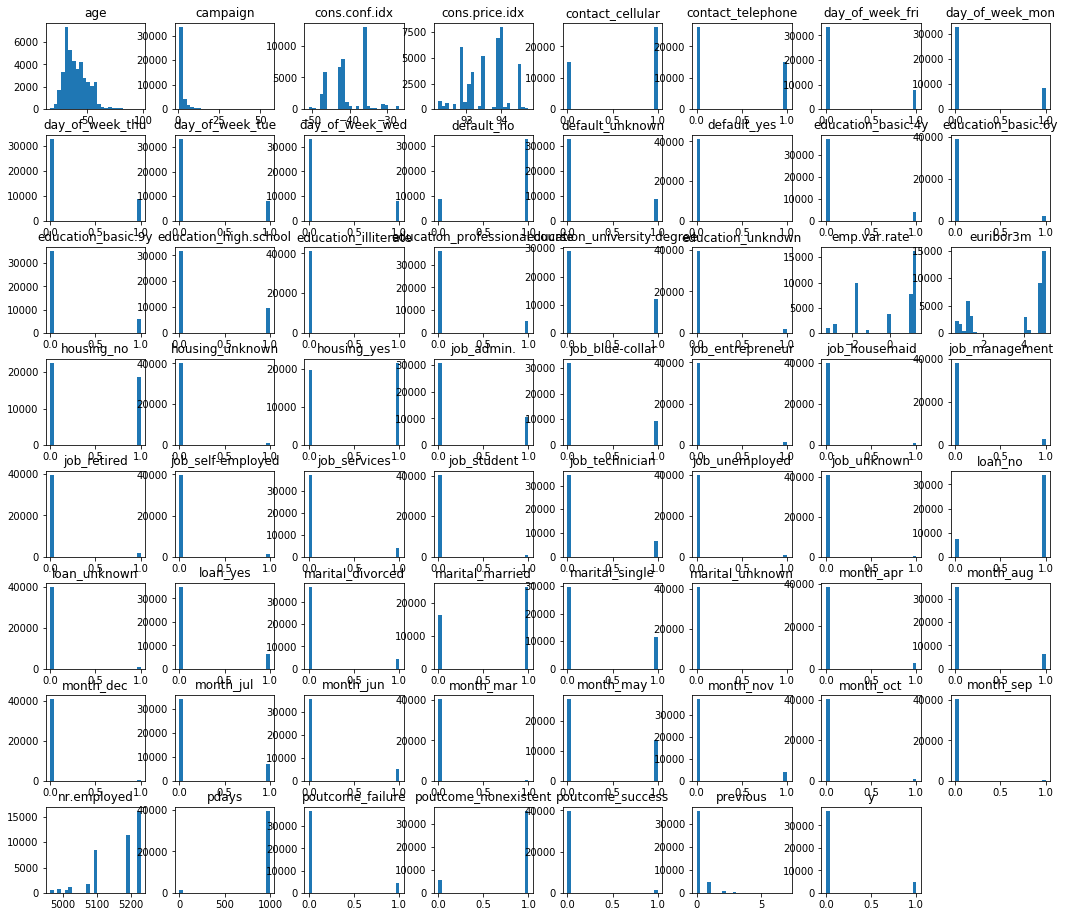

In [202]:
df.hist(figsize=(18,16), bins=25, grid=False);

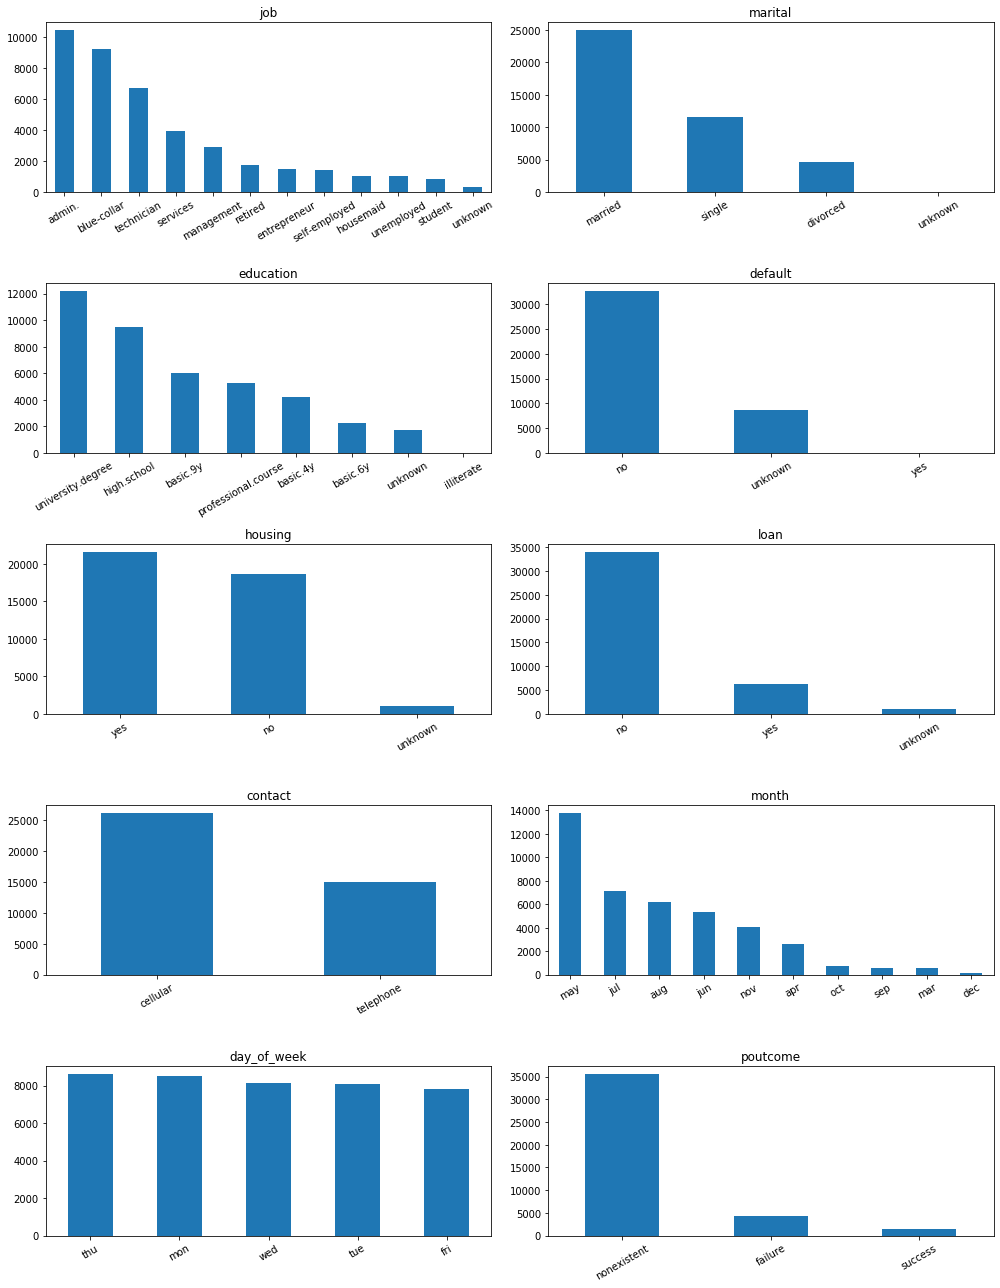

In [162]:
fig, axs = plt.subplots(5, 2)
i=0
for col in df.columns.drop('y'):
    if df[col].dtype==object:
        df[col].value_counts().plot.bar(rot=30, title=col, ax = axs[i//2,i%2])
        i=i+1
fig.set_size_inches(14, 18)
fig.tight_layout();

### Duration

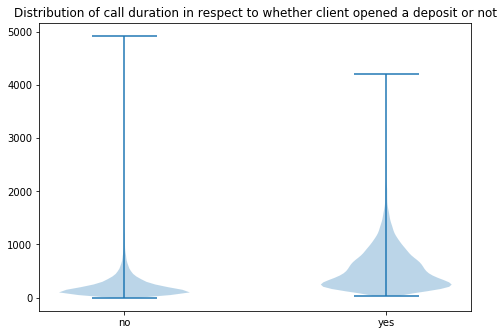

In [190]:
data_to_plot = [df.duration[df['y']=='no'].to_numpy(), df.duration[df['y']=='yes'].to_numpy()]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bp = ax.violinplot(data_to_plot)
ax.set_xticks(np.arange(1, 3))
ax.set_xticklabels(['no', 'yes'])
ax.set_title('Distribution of call duration in respect to whether client opened a deposit or not')
plt.show()

Variable "duration" is the duration of last call with the client. Including this variable as it is in our model could lead to a huge data leakage - for example if duration = 0 then y='no'. There seem to be two possible ways of coping with the problem. 

First one would be deleting observations with duration below a threshold, e.g. 30 seconds. However, from a business perspective, this solution is not ideal. Our goal is to make marketing strategies more effective - meaning consuming less of our resources. Clients who do not pick up phone, still are taking up our time to make a call to them. Secondly, duration of the call is not known before making the call - and ideally we would like to know client's propensity to our campaign before making the call.

Therefore, our decision is to remove 'duration' variable from our dataset.

In [0]:
df = df.drop("duration", axis=1)

## Data preparation

Firstly, target variable needs to be recoded into binary form.

In [0]:
df["y"] = (df.y=="yes").astype(int)

Then, we will recode all variables with nominal levels to binary form (aka One Hot Encoding).

In [0]:
levCols = []
numCols = []
for col in df.columns:
    if df[col].dtype==object:
        levCols.append(col)
    else:
        numCols.append(col)
dummLev = pd.get_dummies(df[levCols])
df = pd.concat([df[numCols], dummLev], axis=1)

In [195]:
df.head(10)

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
5,45,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
6,59,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
7,41,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
8,24,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
9,25,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


## Logistic regression

In [0]:
# Seperate the features from the target variable
y = df.y
X = df.drop('y', axis=1)

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=58)

# Train model
log_reg = LogisticRegression(solver='liblinear').fit(X_train, y_train)

# Predict on training dataset
log_reg_pred = log_reg.predict(X_test)



In [198]:
# Checking accuracy
print(classification_report(y_test, log_reg_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     11020
           1       0.65      0.21      0.32      1337

    accuracy                           0.90     12357
   macro avg       0.78      0.60      0.63     12357
weighted avg       0.88      0.90      0.88     12357



In [199]:
print('Precision Score: ', precision_score(y_test, log_reg_pred))

Precision Score:  0.6492027334851936


In [200]:
print('Recall Score: ', recall_score(y_test, log_reg_pred))

Recall Score:  0.2131637995512341


In [201]:
f1_score(y_test, log_reg_pred)

0.32094594594594594